## ARMA模型分析时间序列

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import os
path = r"F:\Diverse\statistics\Python_data_analysis\Kaggle项目\20171024-Grocery_sale"
os.chdir(path)

%matplotlib inline

### 导入数据

In [2]:
#load transactions info
dtypes = {"transactions": "int16", "store_nbr": "int8"}
transactions = pd.read_csv(r"dataset/transactions.csv", parse_dates=["date"], dtype=dtypes)

#### transactions数据分析

In [3]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
date            83488 non-null datetime64[ns]
store_nbr       83488 non-null int8
transactions    83488 non-null int16
dtypes: datetime64[ns](1), int16(1), int8(1)
memory usage: 896.9 KB


In [4]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [5]:
transactions.nsmallest(7,columns=["transactions"])

,date,store_nbr,transactions
65479,2016-09-07,43,5
52392,2016-01-02,2,6
52428,2016-01-04,1,10
57950,2016-04-17,53,33
58003,2016-04-18,53,54
74018,2017-02-20,30,97
59594,2016-05-18,54,179


In [6]:
transactions.nlargest(5,columns=["transactions"])

,date,store_nbr,transactions
52011,2015-12-23,44,8359
71010,2016-12-23,44,8307
16570,2013-12-23,44,8256
33700,2014-12-23,44,8120
16572,2013-12-23,46,8001


#### 数据可视化

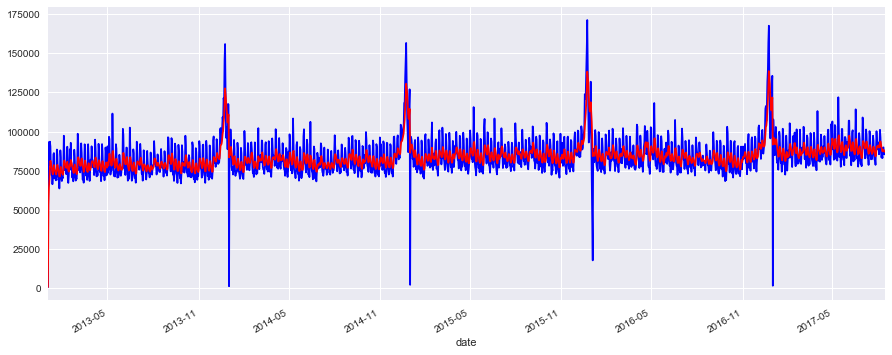

In [7]:
transaction_groupby_date = transactions.groupby("date")["transactions"].sum()
transaction_groupby_date_ewm = pd.Series.ewm(transaction_groupby_date, span=7).mean()

fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot()
transaction_groupby_date.plot(kind="line",style="b",ax=ax)
transaction_groupby_date_ewm.plot(kind="line", style="r-", ax=ax)

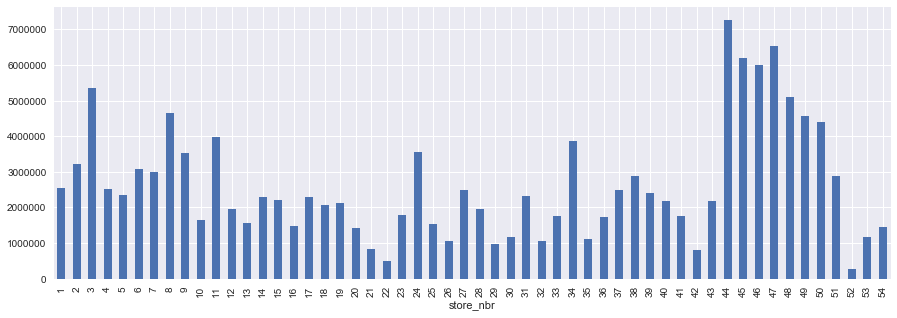

In [8]:
transactions_groupby_store = transactions.groupby("store_nbr")["transactions"].sum()

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot()
transactions_groupby_store.plot(kind="bar",ax=ax)

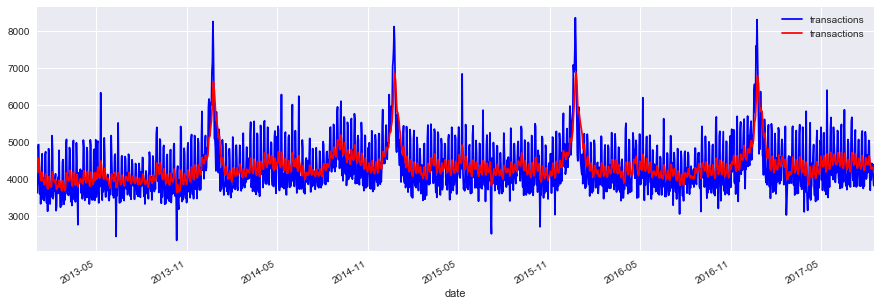

In [9]:
# 检查交易量最高的44号商店的日交易量
transactions_44 = transactions[transactions.store_nbr==44][["date","transactions"]].set_index("date")
transactions_44_ewm = pd.DataFrame.ewm(transactions_44,span=10).mean()

ax = transactions_44.plot(kind="line",style="b",figsize=(15,5))
transactions_44_ewm.plot(kind="line", style="r-", ax=ax)

In [10]:
transactions_44.nlargest(5,columns=["transactions"])

,transactions
date,
2015-12-23,8359
2016-12-23,8307
2013-12-23,8256
2014-12-23,8120
2015-12-24,7700


In [11]:
transactions_44.nsmallest(5,columns=["transactions"])

,transactions
date,
2013-10-11,2333
2013-06-11,2438
2015-07-07,2510
2015-10-13,2699
2013-03-26,2756


In [12]:
transaction_groupby_date.nsmallest(5)

date
2013-01-01      770.0
2014-01-01     1327.0
2017-01-01     1642.0
2015-01-01     2202.0
2016-01-04    17829.0
Name: transactions, dtype: float64

In [13]:
transactions[transactions.date=="2014-01-01"]

,date,store_nbr,transactions
16908,2014-01-01,25,840
16909,2014-01-01,36,487


- 圣诞节时期交易量上升迅速，每年1月1日交易量惨淡
- 12月23日和1月1日可视为outliers-date
- 呈现明显的周期性，period = 1 year
- 交易量正常范围在60k～100k之间
- 1月1日统计的商店数量很少，仅有个位数，建议将其去除，后续分析可采用指数加权平均值分析

### 检验时间序列的稳定性
- 恒定的平均数/方差
- 不随时间变化的自协方差
- 绘制移动统计窗口/DF检验

#### ADF检验 
- Augmented Dickey-Fuller test

In [14]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #detemine rolling statistics
    timeseries = pd.Series(timeseries)
    rolmean = timeseries.rolling(window="7d").mean()
    rolstd = timeseries.rolling(window="7d").std()
    
    #plot rolling statistics
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111)
    orig = ax.plot(timeseries, color="blue", label="original")
    mean = ax.plot(rolmean, color="red", label="rolling_mean")
    std = ax.plot(rolstd, color="black", label="rolling_std")
    plt.legend(loc="best")
    plt.title("rolling mean & standard deviation")
    plt.show(block=False)
    
    #perform dickey-fuller test
    print("results of dickey-fuller test: ")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index=["test statistic","p-value", "#lags used","number of observations used"])
    for key,value in dftest[4].items():
        dfoutput["critial value (%s) "%key] = value
    print(dfoutput)

D:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


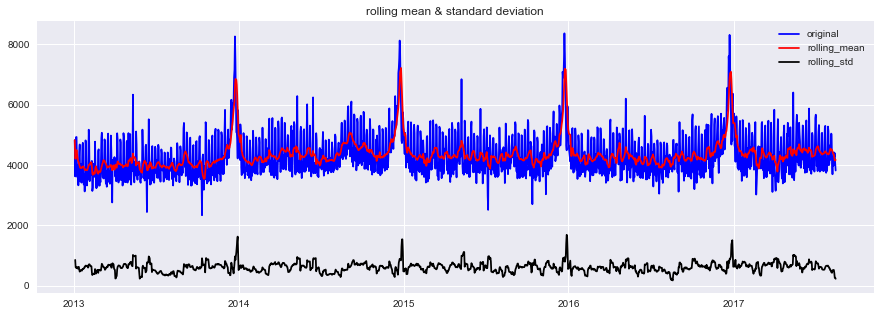

results of dickey-fuller test: 
test statistic                -6.018087e+00
p-value                        1.516665e-07
#lags used                     2.300000e+01
number of observations used    1.653000e+03
critial value (1%)            -3.434312e+00
critial value (5%)            -2.863290e+00
critial value (10%)           -2.567702e+00
dtype: float64


In [15]:
# 采用44号商店数据
test_stationarity(transactions_44.transactions)

**显著性水平表示为当原假设成立时，拒绝原假设的概率为多少**:
- 1%、%5、%10不同程度拒绝原假设的统计值和ADF Test result的比较，ADF Test result同时小于1%、5%、10%即说明非常好地拒绝该假设
- P-value是否非常接近0,接近0，则可以显著地拒绝原假设
- 本数据中，adf结果为-6.02， 小于三个level的统计值；P-value 为 1.51e-7.

**能拒绝原假设，平稳序列**

#### 消除趋势方法
- 转换(变换为log\sqrt等)->平滑/聚合

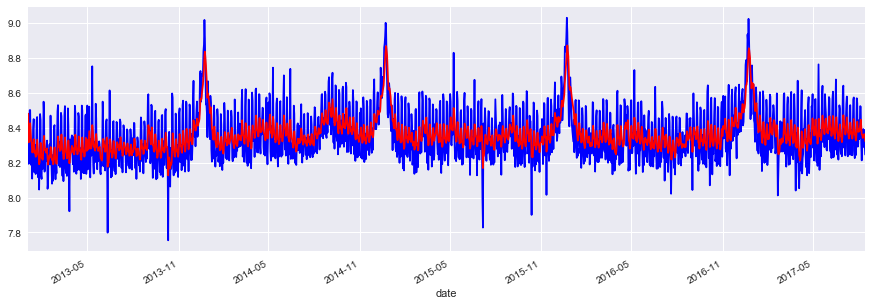

In [16]:
train_log = np.log(transactions_44.transactions)
train_log_ewm = pd.Series.ewm(train_log,span=7).mean()
ax = train_log.plot(kind="line",style="b",figsize=(15,5))
train_log_ewm.plot(kind="line",style="r-",ax=ax)

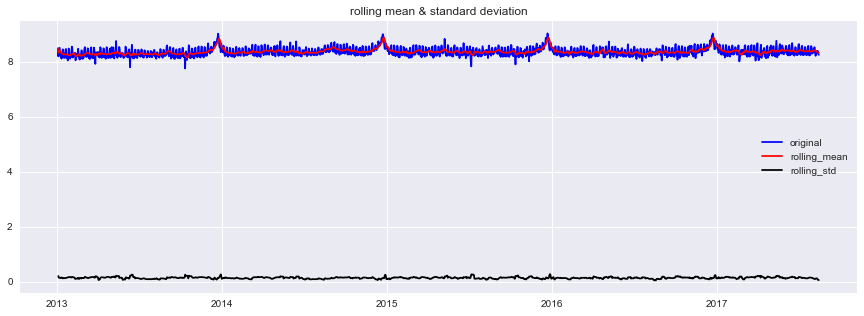

results of dickey-fuller test: 
test statistic                   -5.520010
p-value                           0.000002
#lags used                       21.000000
number of observations used    1655.000000
critial value (1%)               -3.434307
critial value (5%)               -2.863288
critial value (10%)              -2.567701
dtype: float64


In [17]:
test_stationarity(train_log)

### 预测时间序列
- ARIMA，自回归整合移动平均数模型，线性回归方程
- 模型参数,ACF自相关函数/PACF偏自相关函数
 - p AR自回归项数
 - q MA移动平均项数
 - d 差分阶数

#### 绘制自相关/偏相关图(acf/pacf)

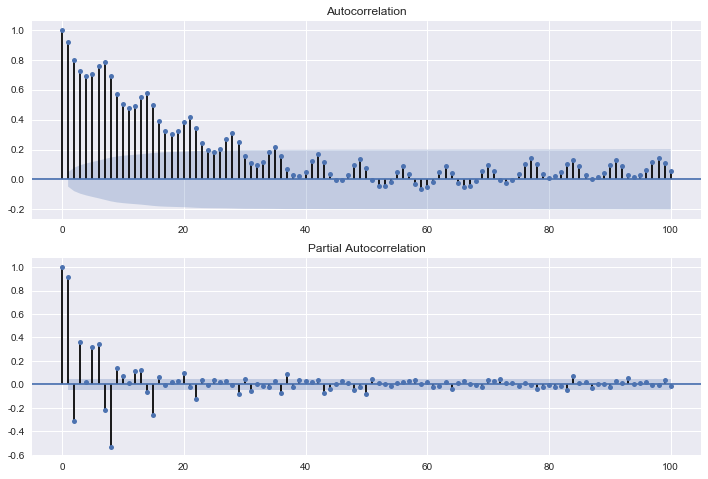

In [18]:
import statsmodels.api as sm
train_sm = train_log_ewm
train_sm.dropna(inplace=True)
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_sm,lags=100,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_sm,lags=100,ax=ax2)

- acf和pacf表现出拖尾特征，选用ARIMA模型

#### 选取最佳p、q值
- AIC/BIC准则选取

In [19]:
from statsmodels.tsa.stattools import arma_order_select_ic

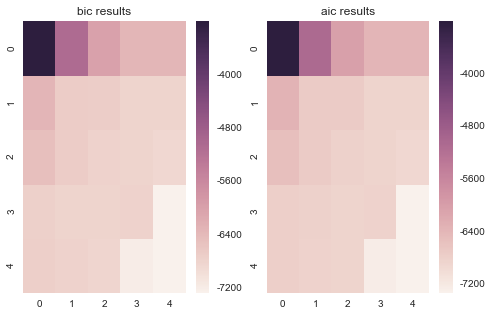

In [20]:
result = arma_order_select_ic(train_log_ewm, max_ar=4, max_ma=4,ic=["aic","bic"],trend="c",fit_kw={"maxiter":500})
plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
plt.title('bic results')
sns.heatmap(result.bic);
plt.subplot(1,2,2)
plt.title('aic results')
sns.heatmap(result.aic);

In [21]:
result.aic_min_order

(4, 4)

#### 模型检验
- 白噪声检验。原假设：时间序列是白噪声
- 预测误差是否为mean=0且std=constant的正态分布
- 观察连续预测误差是否自相关

In [22]:
from statsmodels.tsa.arima_model import ARIMA

In [23]:
model = ARIMA(train_log_ewm,order=(4,0,4))
model_fit = model.fit(disp=False,maxiter=500)

,count,mean,std,min,25%,50%,75%,max
residuals,1677.0,-0.000117,0.027243,-0.154662,-0.018071,0.001724,0.018098,0.117087


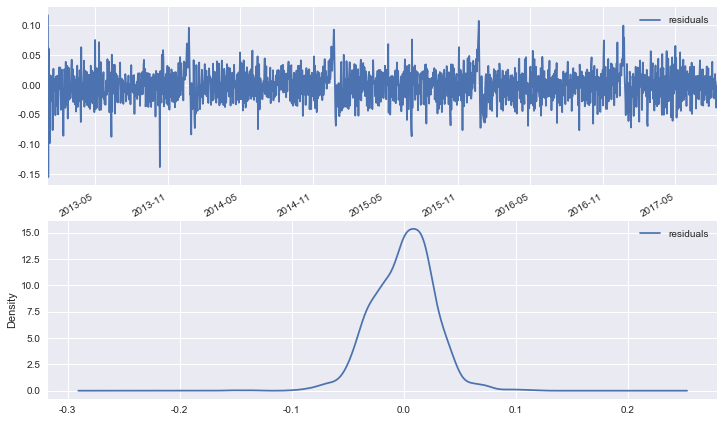

In [24]:
#绘制残差图
residuals = pd.DataFrame(model_fit.resid,columns=["residuals"])
fig, axes = plt.subplots(nrows=2,ncols=1,figsize=(12,8))
residuals.plot(ax=axes[0])
residuals.plot(kind="kde",ax=axes[1])
residuals.describe().T

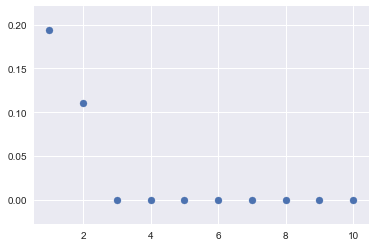

In [25]:
#白噪声检验
from statsmodels.stats.diagnostic import acorr_ljungbox
(state,pvalue) = acorr_ljungbox(residuals, lags=10)
plt.scatter(range(1,11),pvalue,)

#### 模型验证集检测
- 分割数据集为train,dev
- log数据还原

In [26]:
forecast_len = 200
size = int(len(train_log_ewm)-forecast_len)
train, dev = train_log_ewm[:size], train_log_ewm[size:]
print(train.shape, dev.shape)

(1477,) (200,)


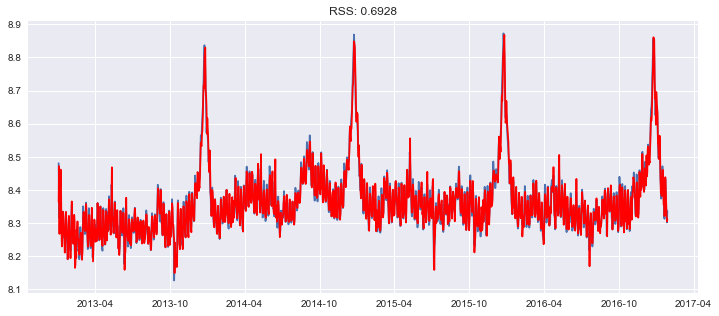

In [27]:
model = ARIMA(train, order=(8,0,6))
results = model.fit(disp=False,maxiter=500)
plt.figure(figsize=(12,5))
plt.plot(train)
plt.plot(results.fittedvalues, color="red")
plt.title('RSS: %.4f'% sum((results.fittedvalues-train)**2))

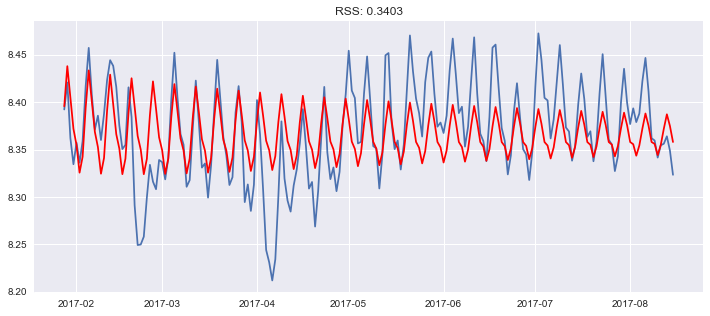

In [28]:
forecast,stderr,conf_int= results.forecast(200)
forecast = pd.Series(forecast,index=dev.index)
plt.figure(figsize=(12,5))
plt.plot(dev)
plt.plot(forecast, color="red")
plt.title('RSS: %.4f'% sum((dev-forecast)**2))

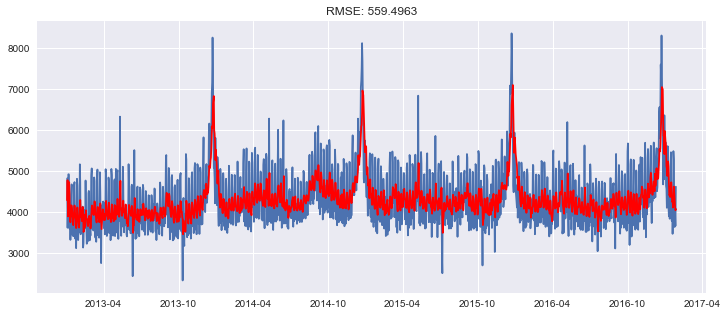

In [29]:
# 数据还原
predictions_ARIMA = pd.Series(results.fittedvalues,copy=True)
predictions = np.exp(predictions_ARIMA)
plt.figure(figsize=(12,5))
plt.plot(transactions_44[:size])
plt.plot(predictions,color="r")
plt.title("RMSE: %.4f" %np.sqrt(sum((predictions-transactions_44.transactions[:size])**2)/size))

#### 测试集预测
- 预测单个店铺当日的总交易量
- 根据历史数据中不同商品的销售量加权

In [30]:
#test set
dtypes = {"store_nbr": "int64",
         "item_nbr": "int64",
         "onpromotion": bool}
test = pd.read_csv(r"dataset/test.csv", index_col="id", parse_dates=["date"], dtype=dtypes)

D:\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [31]:
test.shape

(3370464, 4)

In [32]:
test_44 = test[test.store_nbr==44]
test_44.head()

,date,store_nbr,item_nbr,onpromotion
id,,,,
125664783,2017-08-16,44,96995,False
125664784,2017-08-16,44,99197,False
125664785,2017-08-16,44,103501,False
125664786,2017-08-16,44,103520,False
125664787,2017-08-16,44,103665,False


In [33]:
#预测当日交易量
model = ARIMA(train_log_ewm, order=(8,0,6))
results = model.fit(disp=False,maxiter=500)
forecast,stderr,conf_int= results.forecast(16)
predictions = np.exp(forecast)
print(predictions[:10])

[ 4144.5031936   4082.86709646  4143.1498689   4253.91518087  4361.70168649
  4265.87414888  4150.0705017   4172.7946565   4110.36422504  4168.76074921]


In [34]:
#根据历史数据加权
dtypes = {"store_nbr": "int64",
         "item_nbr": "int64",
         "unit_sales": "float64",
         "onpromotion": bool}
train_sample = pd.read_csv(r"dataset/train.csv", index_col="id", parse_dates=["date"],
                     dtype=dtypes, skiprows=range(1, 88042204))

D:\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [35]:
train_sample.shape

(37454837, 5)

In [36]:
item = train_sample.loc[(train_sample.date<"2017-01-01")&(train_sample.date>"2016-01-01")&(train_sample.store_nbr==44)].groupby("item_nbr")["unit_sales"].sum().to_frame("unit_sales")
item["weights"] = item/item.sum()
item["pred_sales"] = predictions[0] * item.weights
item.head()

,unit_sales,weights,pred_sales
item_nbr,,,
99197,471.0,0.000072,0.297612
103520,1645.0,0.000251,1.039430
103665,1458.0,0.000222,0.921270
105574,2595.0,0.000396,1.639709
105575,3506.0,0.000535,2.215345


### 依据商店类别预测时间序列

#### 商店聚类
- hierarchical clustering,树状图确定分类数目
- agglomerative进行聚类操作

In [37]:
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.cluster import AgglomerativeClustering

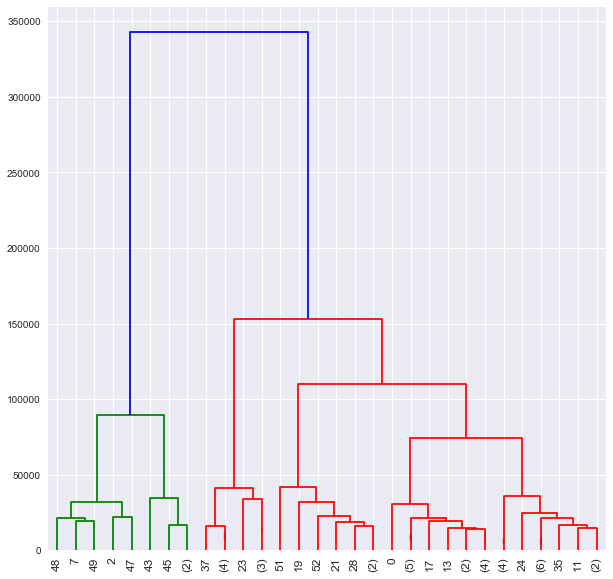

In [38]:
hc = transactions.groupby(["store_nbr","date"]).transactions.mean().unstack(level=1).fillna(0)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
w = ward(hc)
dendrogram(w,truncate_mode='lastp',ax=ax,leaf_font_size=12,leaf_rotation=90,show_contracted=True)
plt.show()

In [39]:
#divide into 6 cluster
clustering = AgglomerativeClustering(n_clusters=6)
cluster = clustering.fit_predict(hc)
# maping form store_nbr to cluster_nbr
maps = dict(zip(hc.index.values,cluster))

#### transactions数据映射
- 根据maps，将store_nbr映射为cluster_nbr

In [40]:
transactions["cluster_nbr"] = transactions.store_nbr.map(maps)
train_sample["cluster_nbr"] = train_sample.store_nbr.map(maps)
test["cluster_nbr"] = test.store_nbr.map(maps)

In [41]:
test.head()

,date,store_nbr,item_nbr,onpromotion,cluster_nbr
id,,,,,
125497040,2017-08-16,1,96995,False,5
125497041,2017-08-16,1,99197,False,5
125497042,2017-08-16,1,103501,False,5
125497043,2017-08-16,1,103520,False,5
125497044,2017-08-16,1,103665,False,5


#### 定义操作函数
- 不同类别的时间序列曲线
- acf/pacf图
- 预测函数modeling

In [42]:
def clustering_plot(cluster=3):
    train = transactions[transactions.cluster_nbr==cluster][["date","transactions"]].set_index("date").groupby("date").sum()
    train_ewm = pd.Series.ewm(train,span=7).mean()
    ax = train.plot(kind="line",style="b",figsize=(12,5))
    train_ewm.plot(kind="line", style="r-",ax=ax)
    return np.log(train), np.log(train_ewm)

In [43]:
def correlation_plot(train_log):
    train_sm = train_log
    train_sm.dropna(inplace=True)
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(train_sm,lags=100,ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(train_sm,lags=100,ax=ax2)

In [44]:
def modeling(train_log_ewm,order=(8,0,6),day=16):
    model = ARIMA(train_log_ewm, order=order)
    results = model.fit(disp=False,maxiter=500)
    forecast,stderr,conf_int= results.forecast(day)
    predictions = np.exp(forecast)
    print(predictions[:10])
    return predictions

In [45]:
from datetime import datetime

In [72]:
def mergeresult(cluster,pred,test):
    m = pd.DataFrame(columns=["id","date","item_nbr","cluster_nbr","prediction"])
    testmerge = test.copy()
    testmerge.reset_index(inplace=True)
    for j in range(cluster):
        item = itemall[j].copy()
        #item = train_sample.loc[(train_sample.date<"2017-08-15")&(train_sample.date>"2016-08-15")&(train_sample.cluster_nbr==j)].groupby("item_nbr")["unit_sales"].sum().to_frame("unit_sales")
        weights = item.unit_sales.values/item.values.sum()
        prediction = pred[j]
        n = len(prediction)
        for i in range(n):
            pred_sales = prediction[i] * weights
            date = datetime(2017,8,16+i)
            data = pd.DataFrame({"item_nbr":item.index.values,"prediction":pred_sales})
            data["date"] = date
            data["cluster_nbr"] = j
            t = testmerge.loc[(testmerge.date==date)&(testmerge.cluster_nbr==j)].drop(axis=1,labels=["store_nbr","onpromotion"])
            merge = pd.merge(t, data, how="left",on=["date","item_nbr","cluster_nbr"])
            merge.fillna(pred_sales.mean(),inplace=True)
            m = pd.concat([m,merge])
    m.drop(axis=1,labels=["date","item_nbr","cluster_nbr"],inplace=True)
    mmerge= pd.merge(testmerge,m,how="left",on="id")
    return mmerge

In [56]:
train_sample.head()

,date,store_nbr,item_nbr,unit_sales,onpromotion,cluster_nbr
id,,,,,,
88042203,2016-08-14,54,2027203,2.0,False,1
88042204,2016-08-14,54,2027252,8.0,False,1
88042205,2016-08-15,1,103665,1.0,False,5
88042206,2016-08-15,1,105574,1.0,False,5
88042207,2016-08-15,1,105575,19.0,False,5


item = train_sample.loc[(train_sample.date<"2017-08-15")&(train_sample.date>"2016-08-15")&(train_sample.cluster_nbr==5)].groupby("item_nbr")["unit_sales"].sum().to_frame("unit_sales")
item5 = item.copy()
itemall = [item0,item1,item2,item3,item4,item5]

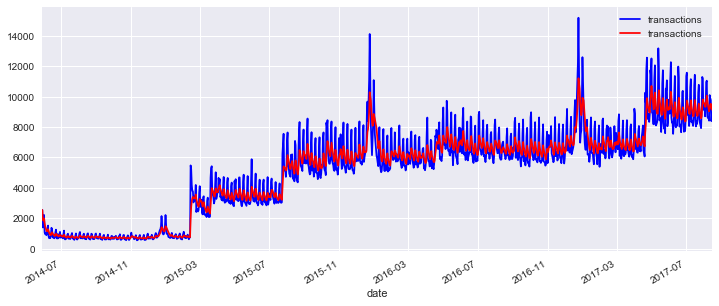

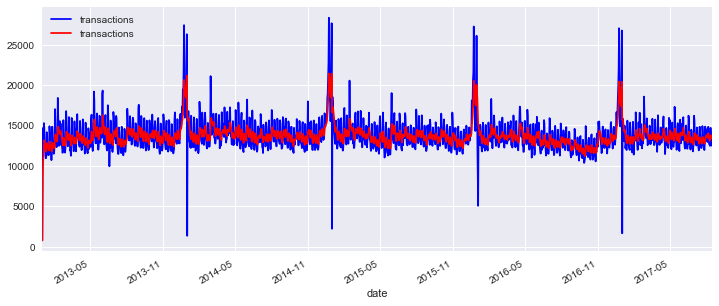

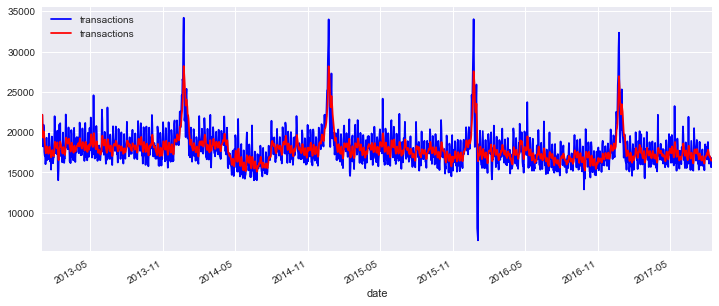

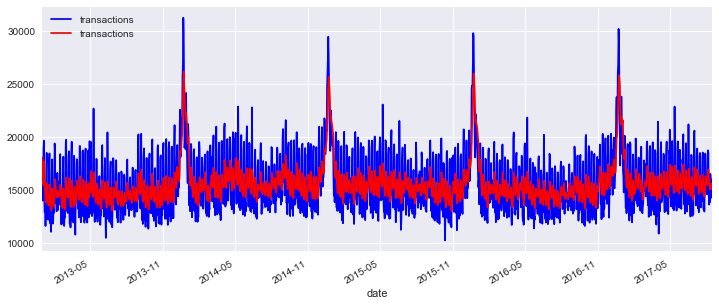

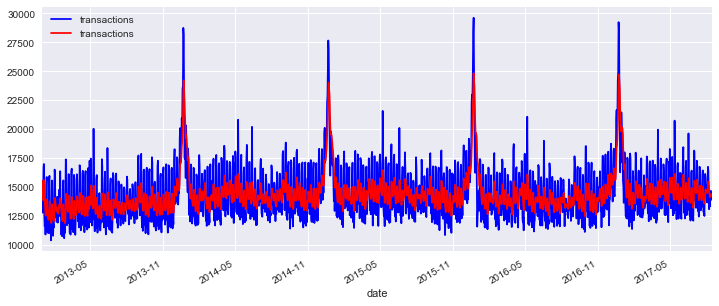

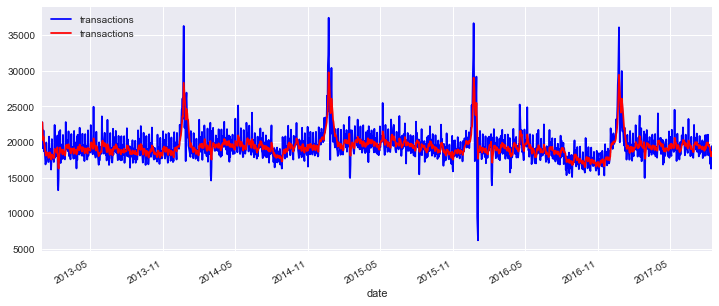

In [47]:
train0,train0_ewm = clustering_plot(0)
train1,train1_ewm = clustering_plot(1)
train2,train2_ewm = clustering_plot(2)
train3,train3_ewm = clustering_plot(3)
train4,train4_ewm = clustering_plot(4)
train5,train5_ewm = clustering_plot(5)

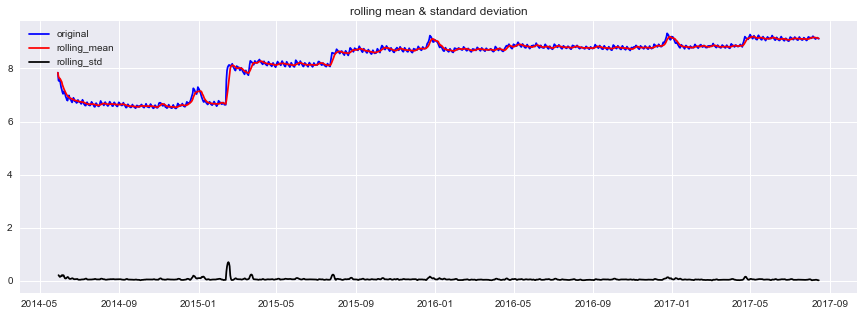

results of dickey-fuller test: 
test statistic                   -1.326008
p-value                           0.617191
#lags used                       23.000000
number of observations used    1143.000000
critial value (1%)               -3.436084
critial value (5%)               -2.864072
critial value (10%)              -2.568118
dtype: float64


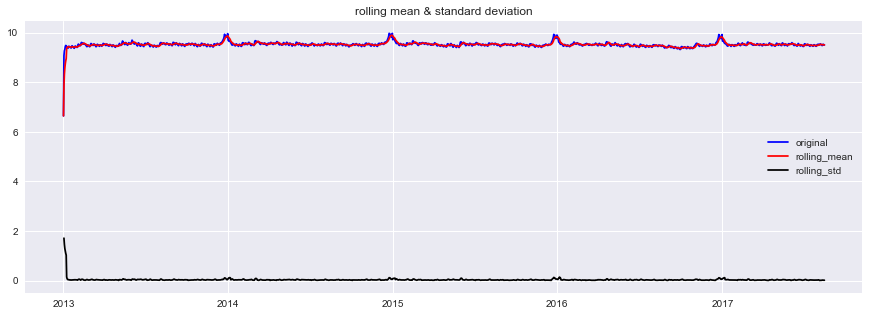

results of dickey-fuller test: 
test statistic                -6.674611e+00
p-value                        4.497976e-09
#lags used                     2.300000e+01
number of observations used    1.658000e+03
critial value (1%)            -3.434300e+00
critial value (5%)            -2.863285e+00
critial value (10%)           -2.567699e+00
dtype: float64


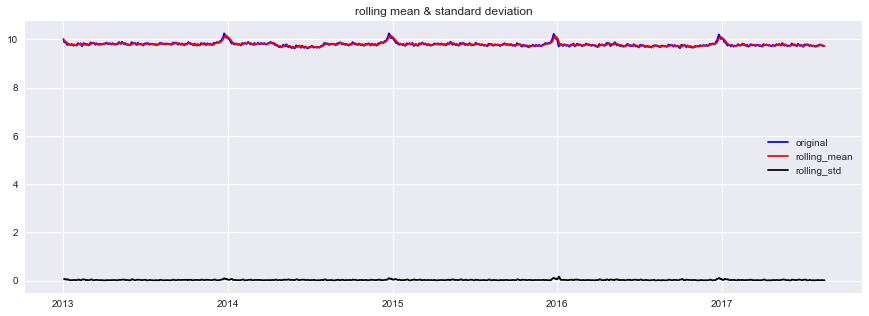

results of dickey-fuller test: 
test statistic                   -4.555852
p-value                           0.000156
#lags used                       25.000000
number of observations used    1652.000000
critial value (1%)               -3.434315
critial value (5%)               -2.863291
critial value (10%)              -2.567702
dtype: float64


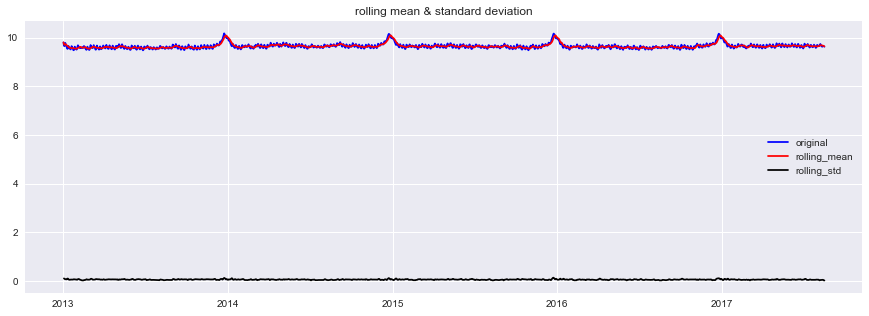

results of dickey-fuller test: 
test statistic                   -5.481909
p-value                           0.000002
#lags used                       23.000000
number of observations used    1653.000000
critial value (1%)               -3.434312
critial value (5%)               -2.863290
critial value (10%)              -2.567702
dtype: float64


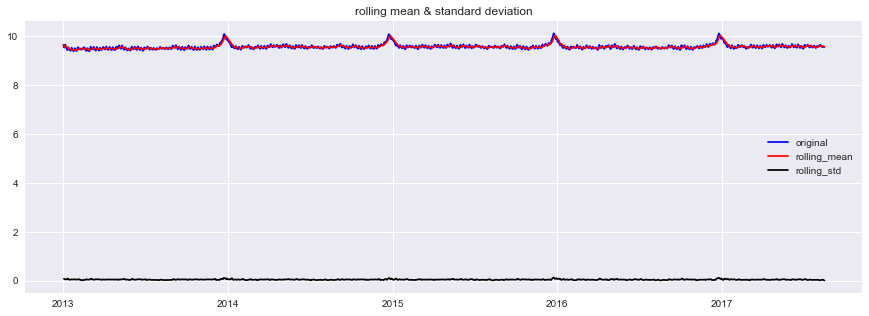

results of dickey-fuller test: 
test statistic                   -5.532882
p-value                           0.000002
#lags used                       23.000000
number of observations used    1653.000000
critial value (1%)               -3.434312
critial value (5%)               -2.863290
critial value (10%)              -2.567702
dtype: float64


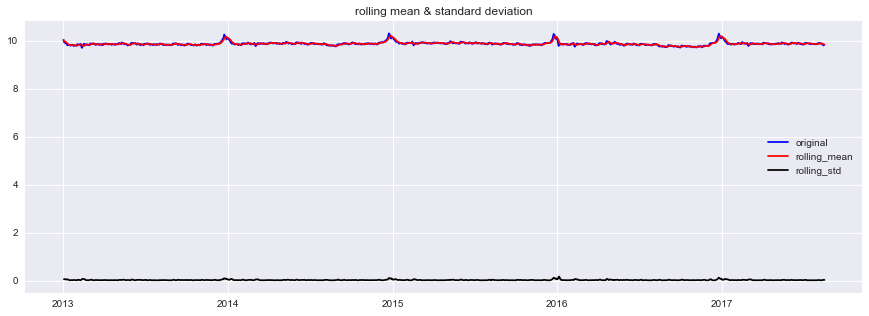

results of dickey-fuller test: 
test statistic                -5.802244e+00
p-value                        4.602164e-07
#lags used                     2.200000e+01
number of observations used    1.655000e+03
critial value (1%)            -3.434307e+00
critial value (5%)            -2.863288e+00
critial value (10%)           -2.567701e+00
dtype: float64


In [48]:
test_stationarity(train0_ewm.transactions)
test_stationarity(train1_ewm.transactions)
test_stationarity(train2_ewm.transactions)
test_stationarity(train3_ewm.transactions)
test_stationarity(train4_ewm.transactions)
test_stationarity(train5_ewm.transactions)

- cluster==0为非平稳序列，需进一步处理

#### cluster-1预测

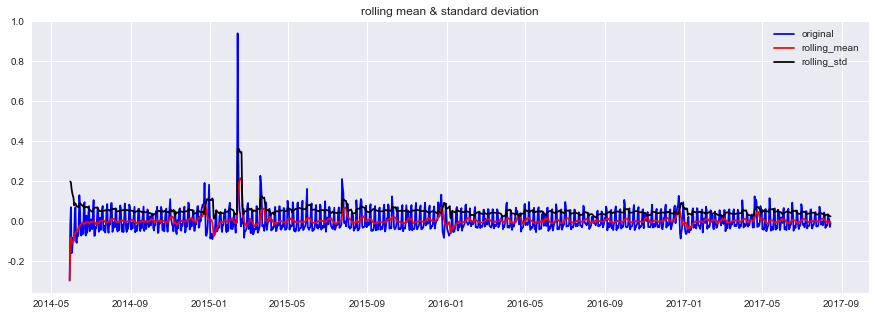

results of dickey-fuller test: 
test statistic                -8.254362e+00
p-value                        5.285980e-13
#lags used                     2.200000e+01
number of observations used    1.143000e+03
critial value (1%)            -3.436084e+00
critial value (5%)            -2.864072e+00
critial value (10%)           -2.568118e+00
dtype: float64


In [49]:
t0 = train0_ewm.transactions.diff().dropna()
test_stationarity(t0)

In [50]:
day = 16
model = ARIMA(t0, order=(4,0,4))
results = model.fit(disp=False,maxiter=500)
forecast,stderr,conf_int= results.forecast(day)
prediction_logs = train0_ewm.values[-1] + np.cumsum(forecast)
predictions0 = np.exp(prediction_logs)
print(predictions0)

[ 9137.89175133  9044.21726397  9102.78510375  9481.92642039  9636.39415141
  9366.39103391  9208.24410255  9232.8173733   9145.1064891   9188.19338634
  9537.99954982  9672.4170421   9411.82924016  9279.77122018  9325.55668138
  9242.22473522]


#### 总模型预测

In [51]:
predictions1 = modeling(train1_ewm,order=(3,0,3))

[ 13300.82128532  13188.11639395  13257.91289347  13437.69547286
  13572.4052477   13540.30642753  13350.97631321  13134.93503731
  13036.56321161  13108.44503651]


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [52]:
predictions2 = modeling(train2_ewm,order=(4,0,4))

[ 16547.34782202  16643.23977449  16863.37126291  17062.82085128
  17123.7521795   17033.80143816  16895.11769258  16842.60054093
  16943.14121377  17149.04225242]


In [53]:
predictions3 = modeling(train3_ewm,order=(4,0,4))

[ 14892.35120556  14771.31309614  15141.81404184  15636.62096139
  15886.78182479  15696.87963936  15227.18243092  14845.45010861
  14831.05462078  15195.86149892]


In [54]:
predictions4 = modeling(train4_ewm,order=(4,0,4))

[ 14041.70632881  13968.32392043  14211.86407363  14533.29232513
  14687.68361496  14554.05833053  14239.92299539  13986.72085793
  13979.24218094  14221.29390271]


In [55]:
predictions5 = modeling(train5_ewm,order=(4,0,4))

[ 18525.90394465  18574.86390229  18517.71921559  18597.0277782
  18643.70918146  18753.8056844   18785.63976039  18804.14037989
  18766.45690553  18761.5018712 ]


In [73]:
preds = [predictions0,predictions1,predictions2,predictions3,predictions4,predictions5]
results = mergeresult(6,preds,test)
results.describe()

,store_nbr,item_nbr,cluster_nbr,prediction
count,3.370464e+06,3.370464e+06,3.370464e+06,3.370464e+06
mean,2.750000e+01,1.244798e+06,2.500000e+00,3.881807e+00
std,1.558579e+01,5.898362e+05,1.823205e+00,6.327502e+00
min,1.000000e+00,9.699500e+04,0.000000e+00,3.511671e-05
25%,1.400000e+01,8.053210e+05,1.000000e+00,1.018972e+00
50%,2.750000e+01,1.294665e+06,2.000000e+00,2.305079e+00
75%,4.100000e+01,1.730015e+06,5.000000e+00,4.232763e+00
max,5.400000e+01,2.134244e+06,5.000000e+00,1.720519e+02


In [74]:
del train_sample

In [75]:
results.prediction[results.prediction < 0] =0
#results.prediction = results.prediction * 5
results.loc[results["onpromotion"]==True,"prediction"] *= 1.25

D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [76]:
results.head()

,id,date,store_nbr,item_nbr,onpromotion,cluster_nbr,prediction
0,125497040,2017-08-16,1,96995,False,5,0.074227
1,125497041,2017-08-16,1,99197,False,5,0.161623
2,125497042,2017-08-16,1,103501,False,5,4.492531
3,125497043,2017-08-16,1,103520,False,5,2.560833
4,125497044,2017-08-16,1,103665,False,5,3.107658


In [77]:
results.date.unique()

array(['2017-08-16T00:00:00.000000000', '2017-08-17T00:00:00.000000000',
       '2017-08-18T00:00:00.000000000', '2017-08-19T00:00:00.000000000',
       '2017-08-20T00:00:00.000000000', '2017-08-21T00:00:00.000000000',
       '2017-08-22T00:00:00.000000000', '2017-08-23T00:00:00.000000000',
       '2017-08-24T00:00:00.000000000', '2017-08-25T00:00:00.000000000',
       '2017-08-26T00:00:00.000000000', '2017-08-27T00:00:00.000000000',
       '2017-08-28T00:00:00.000000000', '2017-08-29T00:00:00.000000000',
       '2017-08-30T00:00:00.000000000', '2017-08-31T00:00:00.000000000'], dtype='datetime64[ns]')

In [78]:
results = results.rename(columns={"prediction":"unit_sales"})
results.to_csv("results.csv",columns=["id","unit_sales"],index=False,float_format="%.3f")

In [ ]:
train_sample.shape